In [113]:
import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
from tqdm import tqdm

class MLP(nn.Module):
    def __init__(self, layer_sizes=[16, 128, 128, 16], bias=False, device=None):
        super().__init__()
        layers = [layer for i, size in enumerate(layer_sizes[:-1]) for layer in (nn.Linear(size, layer_sizes[i+1], bias, device), nn.ReLU())]
        self.layers = nn.Sequential(*layers[:-1])
    
    def forward(self, x):
        return self.layers(x)
    
def split_MLP(model, n_parts):
    n_lin_layers = len([l for l in model.layers if isinstance(l, nn.Linear)])
    assert n_parts <= n_lin_layers
    
    starts = t.linspace(0, len(model.layers), n_parts + 1).int()[:-1]
    ends = t.linspace(0, len(model.layers), n_parts + 1).int()[1:]
    
    models = [nn.Sequential(*model.layers[s:e]) for s, e in zip(starts, ends)]
    
    return models

filename_pattern = 'mlp-%d.pt'

def split_MLP_and_save(model, n_parts, filename_pattern = filename_pattern):
    models = split_MLP(model, n_parts)
    for i, model in enumerate(models):
        t.save(model, filename_pattern % i)
        
def load_model(rank, filename_pattern=filename_pattern):
    return t.load(filename_pattern % rank)


###################################################################

# Trains model on the identity function
def train(model, batch_size=256, n_steps=10):
    
    shape = (batch_size, model.layers[0].in_features)
    data = lambda: t.randint(-256, 256, (shape)).detach()
    
    optimizer = t.optim.Adam(model.parameters())
    loss_fn = t.nn.MSELoss()
    
    losses = []
    with tqdm(range(n_steps)) as pbar:
        for i in pbar:
            x = data().float()

            optimizer.zero_grad()
            y = model(x)
            loss = loss_fn(x, y)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.detach())
            pbar.set_postfix({'loss': float(loss)})
            
    return losses

In [89]:
model = MLP([128, 256, 256, 256, 128])
split_MLP_and_save(model, 4)

100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 384.82it/s, loss=3.62e+3]


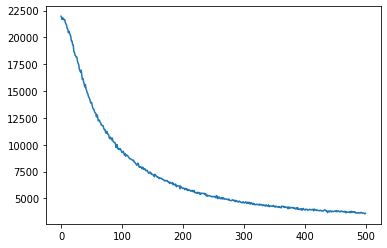

In [90]:
losses = train(model, n_steps=500)
plt.plot(losses);

In [152]:
[p.grad for p in model.parameters()]

[tensor([[-6.2161, -5.4755, -6.2741,  ...,  7.6438,  2.4707, -2.4638],
         [-2.3165, -2.7977,  3.2577,  ...,  0.4599,  4.9748, -1.5924],
         [-2.5122, -3.7245, -0.5638,  ...,  3.7774,  2.9107, -3.2526],
         ...,
         [-0.5895,  1.9955, -7.3904,  ..., -1.0666, -0.4769, -0.8296],
         [ 0.1555,  0.7330, -5.6228,  ...,  5.0281,  1.8236, -1.6734],
         [ 2.0817, -1.6689, -7.8213,  ...,  5.1224,  1.7173,  2.6098]]),
 tensor([[ -1.4940,  -3.6090,  -6.3235,  ...,  -4.4008,  -2.7491, -12.6427],
         [ 17.5478,  17.0942,  18.3686,  ...,  12.4417,  19.9488,  16.9691],
         [  7.3732,   5.0631,  -0.8217,  ...,   6.4245,  -0.9037,   0.5830],
         ...,
         [ -8.3495,  -2.9810,  -1.2587,  ...,   0.3050,  -0.5095,  -4.5297],
         [  2.5303,   3.5465,  10.4417,  ...,   7.1472,   2.3877,   5.8355],
         [ -3.7755,   2.5986,  -2.1001,  ...,  -1.2435,  -3.2732,  -6.5480]]),
 tensor([[ 34.5955,  24.8845,  31.4030,  ...,  33.0480,  28.8213,  31.5392],
   

In [163]:
model_part = load_model(3, 'refactor/'+filename_pattern)

In [169]:
[p.shape for p in model_part.parameters()]

[torch.Size([128, 256]), torch.Size([128])]

In [170]:
model_part

Sequential(
  (0): Linear(in_features=256, out_features=128, bias=True)
)

In [197]:
data = lambda: t.randint(-256, 256, (10, 256))
x = data().float()
y = model_part(x)
y.shape

torch.Size([10, 128])

In [198]:
y

tensor([[  33.8481,  186.8112, -122.4830,  ...,  -62.2399,  -97.5627,
           83.3937],
        [  31.1804,  -16.9459,  -79.1419,  ...,  -11.7387, -112.4717,
          -68.5201],
        [ 101.2213,  -80.9245,   62.2102,  ...,   93.5130,  -22.4523,
          -24.8564],
        ...,
        [  77.8165,  -65.9846, -131.9133,  ...,  -36.1790,  -78.5119,
            8.1192],
        [ -90.7533,    1.1285,    2.9840,  ...,   85.5291,   37.1142,
           42.5019],
        [ -35.2706,  120.8369,  140.3546,  ..., -119.1434,  -53.7117,
           38.3423]], grad_fn=<AddmmBackward0>)

In [199]:
target = lambda: t.randint(-256, 256, (10, 128))

loss_fn = t.nn.MSELoss()
targ = target().float()
loss = loss_fn(targ, y)
loss.backward()

[(p.shape, p.grad.shape) for p in model_part.parameters()]

[(torch.Size([128, 256]), torch.Size([128, 256])),
 (torch.Size([128]), torch.Size([128]))]

In [200]:
x.shape

torch.Size([10, 256])